<a href="https://colab.research.google.com/github/momijizen/Machine-Learning-with-Python-Projects/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2021-02-16 08:48:23--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip      [<=>                 ]  24.88M   889KB/s    in 29s     

2021-02-16 08:48:52 (882 KB/s) - ‘book-crossings.zip’ saved [26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [4]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [5]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print(df_books.shape)
print(df_books.describe())

print(df_ratings.shape)
print(df_ratings.describe())
print(df_ratings.user.unique().shape)

(271379, 3)
              isbn           title           author
count       271379          271379           271378
unique      271379          242154           102042
top     0380706776  Selected Poems  Agatha Christie
freq             1              27              632
(1149780, 3)
             user      rating
count 1149780.000 1149780.000
mean   140386.395       2.867
std     80562.278       3.842
min         2.000       0.000
25%     70345.000       0.000
50%    141010.000       0.000
75%    211028.000       7.000
max    278854.000      10.000
(105283,)


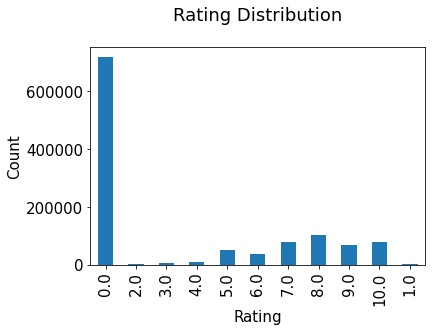

In [7]:
plt.rc("font", size=15)
df_ratings.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [8]:
# remove users with less then 200 ratings
count_user = df_ratings['user'].value_counts()
df_ratings_user = df_ratings[df_ratings['user'].isin(count_user[count_user >= 200].index)]
df_ratings_user

,user,isbn,rating
1456,277427,002542730X,10.000
1457,277427,0026217457,0.000
1458,277427,003008685X,8.000
1459,277427,0030615321,0.000
1460,277427,0060002050,0.000
...,...,...,...
1147612,275970,3829021860,0.000
1147613,275970,4770019572,0.000
1147614,275970,896086097,0.000
1147615,275970,9626340762,8.000


In [9]:
# remove books with less then 100 ratings  
count_book = df_ratings['isbn'].value_counts()
df_ratings_isbn = df_ratings[df_ratings['isbn'].isin(count_book[count_book >= 100].index)]
df_ratings_isbn

,user,isbn,rating
2,276727,0446520802,0.000
8,276744,038550120X,7.000
10,276746,0425115801,0.000
11,276746,0449006522,0.000
12,276746,0553561618,0.000
...,...,...,...
1149749,276690,0064400557,0.000
1149761,276704,0345386108,6.000
1149768,276704,0446605409,0.000
1149771,276704,0743211383,7.000


In [10]:
# merge user >= 200 ratings and book >= 100 ratings
df_ratings_clean = df_ratings_user.merge(df_ratings_isbn, how='inner')
df_ratings_clean

,user,isbn,rating
0,277427,002542730X,10.000
1,277427,0060930535,0.000
2,277427,0060934417,0.000
3,277427,0061009059,9.000
4,277427,0140067477,0.000
...,...,...,...
49776,275970,0804111359,0.000
49777,275970,140003065X,0.000
49778,275970,1400031346,0.000
49779,275970,1400031354,0.000


In [11]:
# join df_books and df_ratings_clean
df_books_ratings = pd.merge(df_books, df_ratings_clean, on="isbn")
df_books_ratings

,isbn,title,author,user,rating
0,0440234743,The Testament,John Grisham,277478,0.000
1,0440234743,The Testament,John Grisham,2977,0.000
2,0440234743,The Testament,John Grisham,3363,0.000
3,0440234743,The Testament,John Grisham,7346,9.000
4,0440234743,The Testament,John Grisham,9856,0.000
...,...,...,...,...,...
49512,0515135739,Eleventh Hour: An FBI Thriller (FBI Thriller (...,Catherine Coulter,236283,0.000
49513,0515135739,Eleventh Hour: An FBI Thriller (FBI Thriller (...,Catherine Coulter,251613,0.000
49514,0515135739,Eleventh Hour: An FBI Thriller (FBI Thriller (...,Catherine Coulter,252071,0.000
49515,0515135739,Eleventh Hour: An FBI Thriller (FBI Thriller (...,Catherine Coulter,256407,0.000


In [12]:
# ratings Matrix
ratings_pivot = df_books_ratings.reset_index().pivot_table(index='title', columns='user', values='rating', aggfunc='mean').fillna(0)
ratings_pivot

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11676,11993,12538,12824,12982,13082,13273,13552,13850,14422,14521,15408,15418,15957,16106,...,264317,264321,264637,265115,265313,265595,265889,266056,266226,266753,266865,266866,267635,268030,268032,268110,268330,268622,268932,269566,269719,269728,269890,270713,270820,271195,271284,271448,271705,273979,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1st to Die: A Novel,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2nd Chance,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4 Blondes,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,...,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Without Remorse,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Year of Wonders,0.000,0.000,0.00

In [13]:
ratings_matrix = csr_matrix(ratings_pivot.values)

In [14]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(ratings_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [15]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  query_index = ratings_pivot.index.get_loc(book)
  distances, indices = model_knn.kneighbors(ratings_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
  recommended_books =[]
  for i in range(1, len(distances.flatten())):
    rec_book = [ratings_pivot.index[indices.flatten()[i]], distances.flatten()[i]]
    recommended_books.append(rec_book)
  recommended_books.reverse()
  recommended_books = [book, recommended_books[:4]]
  return recommended_books

In [16]:
# Development test
get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")

["Where the Heart Is (Oprah's Book Club (Paperback))",
 [["I'll Be Seeing You", 0.8016211],
  ['The Weight of Water', 0.77085835],
  ['The Surgeon', 0.7699411],
  ['I Know This Much Is True', 0.7677075]]]

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [17]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You havn't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075]]]
You passed the challenge! 🎉🎉🎉🎉🎉
